## Imports and Data

We want to create charts of EG data with Altair so let's start by importing some sample [booking data](https://alation/table/4248/) and [customer data](https://alation/table/115791/) using the Qubole Python SDK.

In [26]:
import os
import re
import pandas as pd
from qds_sdk.commands import HiveCommand
from qds_sdk.qubole import Qubole

class QuboleConnector():
    def __init__(self, hcom_api_token, bex_api_token):
        pass

    def query_data(self, sql_query, account):
        if account == 'hcom':
            Qubole.configure(api_token=hcom_api_token)
        else:
            Qubole.configure(api_token=bex_api_token)
                
        cmd = self.execute_query(sql_query)

        if HiveCommand.is_success(cmd.status):
            with open("temp_data.csv", 'w') as writer:
                if account == 'hcom':
                    cmd.get_results(writer, delim=",", inline=False)
                else:
                    cmd.get_results(writer, delim="\t", inline=False)

            clean_query = sql_query.replace('\n', '')
            clean_query = re.sub("\\([^)]*?\\)", "", clean_query)
            heads = re.search('select(.*?)from', clean_query.lower()).group(1).split(',')
            heads = [h.strip() for h in heads]
            heads = [h if ' as ' not in h else re.search(' as (.*)', h).group(1) for h in heads]      
        
            if account == 'hcom':
                query_result = pd.read_csv("temp_data.csv", names = heads)
            else:
                query_result = pd.read_csv("temp_data.csv", names = heads, sep='\t')
        os.remove("temp_data.csv")
        return query_result

    def execute_query(self, sql_query):
        hc_params = ['--query', sql_query]
        hive_args = HiveCommand.parse(hc_params)
        cmd = HiveCommand.run(**hive_args)
        return cmd

Set your Qubole API token(s) which can be found [here](https://api.qubole.com/v2/control-panel#manage-accounts).

In [40]:
my_hcom_api_token='[INSERT-HCOM-TOKEN-HERE]'
my_bex_api_token='[INSERT-HCOM-TOKEN-HERE]' # Set as empty string if you don't have one

# simon's tokens (let him know if you need to use)
# hcom_api_token='e430f9db5ff2473897c52d834f4a65742cdddcadbb43409e8684b7309d26e194'
# bex_api_token='4ddc9f9d5bfd452ab0aaca49625af6082d6f016e57c04cbe8abd64002ed346af'
# hcom_api_token=''
# bex_api_token=''

Instatiate a new Qubole connector object with your token(s):

In [41]:
hcom_con = QuboleConnector(hcom_api_token = my_hcom_api_token, bex_api_token = my_bex_api_token)

# create a separate bex connector object if needed
# bex_con = QuboleConnector(bex_api_token)

In [21]:
bkg_sample_query = """
SELECT 
    local_date
    ,customer_account_id
    ,bkg_id
    ,booking_itin_number
    ,bkg_date_gmt
    ,bkg_timestamp
    ,booking_gross_profit_amount_usd
    ,gross_booking_value_usd
    ,room_nights
    ,guid
    ,supplier_property_id
    ,user_context_pos
    ,brand_name
    ,booking_platform
    ,booking_device
    ,visit_number
    ,visit_page_number
    ,booking_adult_count
    ,booking_child_count
    ,COALESCE(length_of_stay,0) AS length_of_stay
FROM bix_booking.hermes_booking_omniture_order_summary
WHERE gmt_trans_year = '2019'
AND gmt_trans_month < 6
AND YEAR(bkg_date_gmt) = '2019'
AND YEAR(bkg_timestamp) = '2019'
AND bkg_date_gmt != CURRENT_DATE
AND booking_cancel_count = 0
AND user_context_pos IN ('HCOM_UK','HCOM_DE','HCOM_FR','HCOM_ES','HCOM_IT')

DISTRIBUTE BY RAND()
SORT BY RAND()

LIMIT 1000
"""

In [22]:
bkg_sample_df = hcom_con.query_data(bkg_sample_query, account = 'hcom')

In [ ]:
head()

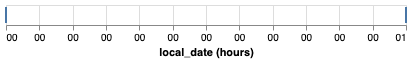

In [93]:
import altair as alt

alt.Chart(bkg_sample_df).mark_tick().encode(
    x='hours(local_date)'
)

In [23]:
#bkg_sample_df.head()
bkg_sample_df.info()
#bkg_sample_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
local_date                         1000 non-null object
customer_account_id                1000 non-null object
bkg_id                             1000 non-null int64
booking_itin_number                1000 non-null int64
bkg_date_gmt                       1000 non-null object
bkg_timestamp                      1000 non-null object
booking_gross_profit_amount_usd    1000 non-null float64
gross_booking_value_usd            1000 non-null float64
room_nights                        1000 non-null int64
guid                               1000 non-null object
supplier_property_id               1000 non-null int64
user_context_pos                   1000 non-null object
brand_name                         1000 non-null object
booking_platform                   1000 non-null object
booking_device                     1000 non-null object
visit_number                       1000 non-null int64
v

In [27]:
cas_sample_query = """
SELECT 
    trvl_acct_email_addr
    ,total_number_net_bookings_all_time
    ,total_number_visits_all_time
    ,total_number_net_room_night_all_time
    ,total_net_gbv_all_time
    ,total_net_gp_all_time
    ,average_gbv_all_time
    ,COALESCE(average_number_days_between_bookings_all_time,0) as average_number_days_between_bookings_all_time
    ,average_length_of_stay_all_time
    ,average_booking_window_all_time
    ,average_daily_rate_all_time
    ,most_booked_posa_all_time
    ,loyalty_account_tier
    ,agg_row_count
    ,most_booked_platform_all_time
    ,COALESCE(total_gbv_business_all_time,0) AS total_gbv_business_all_time
    ,total_number_bookings_business_all_time
    ,COALESCE(total_gbv_family_all_time,0) AS total_gbv_family_all_time
    ,total_number_bookings_family_all_time
    ,COALESCE(total_gbv_domestic_all_time,0) AS total_gbv_domestic_all_time
    ,total_number_bookings_domestic_all_time
FROM bix_cas.customer_attribute_store
WHERE report_date = '2019-05-20'
AND total_number_visits_all_time > 0
AND agg_row_count > 0
AND total_number_net_bookings_all_time > 0
AND most_booked_posa_all_time IN ('United Kingdom','France','Germany','Spain','Italy')

DISTRIBUTE BY RAND()
SORT BY RAND()

LIMIT 1000
"""

In [28]:
cas_sample_df = hcom_con.query_data(cas_sample_query, account = 'hcom')

In [31]:
#cas_sample_df.head()
cas_sample_df.info()
#cas_sample_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
trvl_acct_email_addr                             1000 non-null object
total_number_net_bookings_all_time               1000 non-null int64
total_number_visits_all_time                     1000 non-null int64
total_number_net_room_night_all_time             1000 non-null int64
total_net_gbv_all_time                           1000 non-null float64
total_net_gp_all_time                            1000 non-null float64
average_gbv_all_time                             1000 non-null float64
average_number_days_between_bookings_all_time    1000 non-null float64
average_length_of_stay_all_time                  1000 non-null float64
average_booking_window_all_time                  1000 non-null float64
average_daily_rate_all_time                      1000 non-null float64
most_booked_posa_all_time                        1000 non-null object
loyalty_account_tier                             1